# DDM: Model Validation

This notebook provides an overview of the tools built in the DDM for extracting predictions from your trained DDM and for evauating the performance of the DDM.

## Importing the Dataset

We utilize `hydra` to save the configuration of our datasets and our models. The default configuration is in the `conf/config.yaml` directory:

```YAML
defaults:
  - data: cartpole_st1_at.yaml
  - model: SVR.yaml
  - simulator: gboost_cartpole.yaml
```

Note that the configuration file points to three additional configuration files for each component: the data, the model, and the simulator.

While the configuration file already has default values specified you can override any element of the configuration file using the `overrides` option. For example, we override the data configuration to instead use the `yaml` file specified in `data/cartpole-st_at.yaml` and the model configuration to use the `yaml` file specified in `model/xgboost.yaml`.


In [1]:
from hydra.experimental import initialize, compose
from model_loader import available_models
import logging
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.logging import RichHandler

logging.basicConfig(
    level=logging.INFO,
    format="%(message)s",
    datefmt="[%X]",
    handlers=[RichHandler()]
)
logger = logging.getLogger("ddm_validation")
logger.setLevel(logging.INFO)

In [2]:
initialize(config_path="conf", job_name="model_validation")
cfg = compose(config_name="config", overrides=["data=cartpole_st_at", "model=xgboost"])

/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/cartpole_st_at.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive model/xgboost.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive simulator/gboost_cartpole.yaml in file:///Users/alizaidi-msft/Documents/bonsai/datadrivenmodel/conf.
See https://hydra

In [3]:
cfg["data"]

{'path': 'csv_data/cartpole_at_st.csv', 'full_or_relative': 'relative', 'inputs': 'state', 'outputs': 'state', 'augmented_cols': ['config_length', 'config_masspole', 'action_command'], 'iteration_order': 1, 'episode_col': 'episode', 'iteration_col': 'iteration', 'max_rows': -1, 'scale_data': True}

In [4]:
cfg["model"]

{'name': 'xgboost', 'build_params': {'model_type': 'xgboost', 'halt_model': False, 'num_trees': 50, 'objective': 'reg:squarederror', 'step_size': 0.3, 'device': 'cpu', 'batch_size': 128, 'gamma': 0, 'scale_data': True, 'max_bin': 256}, 'saver': {'filename': 'models/boost/moab/xgboost_model'}, 'sweep': {'run': False, 'search_algorithm': 'bayesian', 'num_trials': 3, 'scoring_func': 'r2'}}

In [5]:
# Extract features from yaml file
input_cols = cfg['data']['inputs']
output_cols = cfg['data']['outputs']
augmented_cols = cfg['data']['augmented_cols']
dataset_path = cfg['data']['path']
iteration_order = cfg['data']['iteration_order']
episode_col = cfg['data']['episode_col']
iteration_col = cfg['data']['iteration_col']
max_rows = cfg['data']['max_rows']

In [6]:
print("DATA STRUCTURE SELECTED:")
print(" - input_cols:", input_cols)
print(" - augmented_cols:", augmented_cols)
print(" - output_cols:", output_cols)

##  Model Definition

The `available_models` dictionary provides wrappers for the available models in this repository. We utilize `cfg["model"]` to load and build the model specified in the `model.yaml` file.

### Training Hyperparameters

Every model has its own hyperparameters, specified through the `cfg["model"]["build_params"]` dictionary, which can be modified directly in the dictionary below or through the `hydra` overrides.

In [7]:
cfg["model"]["build_params"]

{'model_type': 'xgboost', 'halt_model': False, 'num_trees': 50, 'objective': 'reg:squarederror', 'step_size': 0.3, 'device': 'cpu', 'batch_size': 128, 'gamma': 0, 'scale_data': True, 'max_bin': 256}

## Train the Model

In [8]:
def train_models(config=cfg):

    logger.info(f'Model type: {available_models[config["model"]["name"]]}')
    Model = available_models[config["model"]["name"]]
    model = Model()
    logger.info(f"Building model with parameters: {config}")
    model.build_model(
        **config["model"]["build_params"]
    )
    logger.info(f"Loading data from {dataset_path}")
    global X, y
    X, y = model.load_csv(
        input_cols=input_cols,
        output_cols=output_cols,
        augm_cols=list(augmented_cols),
        dataset_path=dataset_path,
        iteration_order=iteration_order,
        episode_col=episode_col,
        iteration_col=iteration_col,
        max_rows=max_rows,
    )

    logger.info(f"Fitting model...")
    model.fit(X, y)
    logger.info(f"Model trained!")

    return model

In [9]:
xgmodel = train_models(cfg)

### Save Model

In [10]:
xgmodel.save_model(filename=cfg["model"]["saver"]["filename"])

### Data Structure of Saved model

In [11]:
logger.info(f"Input_cols:  {xgmodel.features}")
logger.info(f"Output_cols: {xgmodel.labels}")

## Model Evaluations

We provide three methods for evaluating the errors of our trained models:

1. Model predictive error: using a specified metric (such as RMSE) and a test set, we evaluate the metric on the test set.
2. Visualization of per-iteration predictions vs a test set
3. Visualization of sequential predictions vs a test set

### Estimated Prediction Error

In [12]:
from assessment_metrics_loader import available_metrics
rms_error = available_metrics["root_mean_squared_error"]
ms_error = available_metrics["mean_squared_error"]

In [13]:
per_iteration_eval_table = xgmodel.evaluate(X, y, rms_error, marginal=True)

/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: Futur

In [14]:
sequential_eval_table = xgmodel.evaluate_sequentially(
    X, y, rms_error, marginal=True, it_per_episode=50
)
sequential_eval_table

/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass sample_weight=None, multioutput=uniform_average, squared=False as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/sklearn/utils/validation.py:70: Futur

,var,score
0,state_x_position,0.334418
1,state_x_velocity,1.280080
2,state_angle_position,1.050337
3,state_angle_velocity,3.727211


In [15]:
if (per_iteration_eval_table["score"] > 1.0).any():
    logger.warn("Per-iteration assessment error is high. Please, review your model")

if (sequential_eval_table["score"] > 1.0).any():
    logger.warn("Sequentially analyzed assessment error is high. Please, review your model")

/Users/alizaidi-msft/miniconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  """


In [16]:
action_feat = "action_command"

### Per-Iteration Predictions

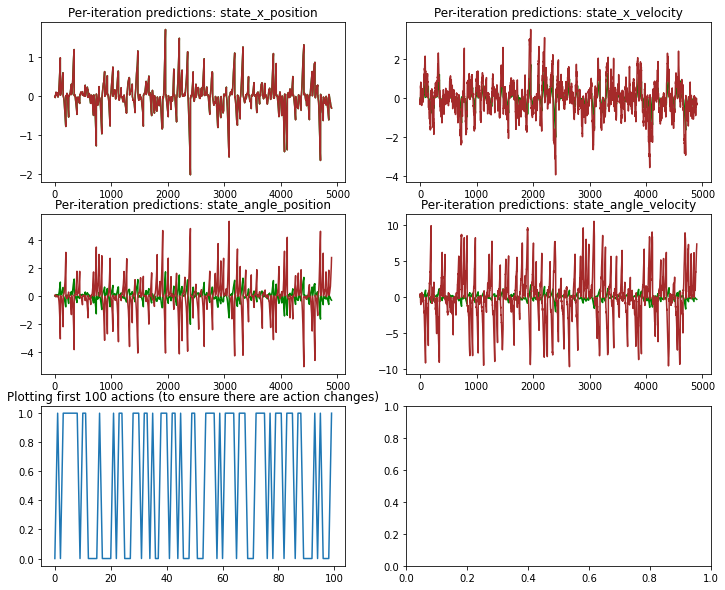

In [17]:
preds = xgmodel.predict(X)

# Plot results graphs
label_count = np.shape(preds)[1]
fig,axs = plt.subplots(3,2,)
for i in range(label_count):
    axs[i//2,i%2].set_title(f"Per-iteration predictions: {xgmodel.labels[i]}")
    axs[i//2,i%2].plot(y[:,0], "green")
    axs[i//2,i%2].plot(preds[:,i], "brown")
    
# Plot action changes
action_idx = xgmodel.features.index(action_feat)
axs[(i+1)//2,(i+1)%2].set_title("Plotting first 100 actions (to ensure there are action changes)")
axs[(i+1)//2,(i+1)%2].plot(X[:100,action_idx])

### Sequential Predictions

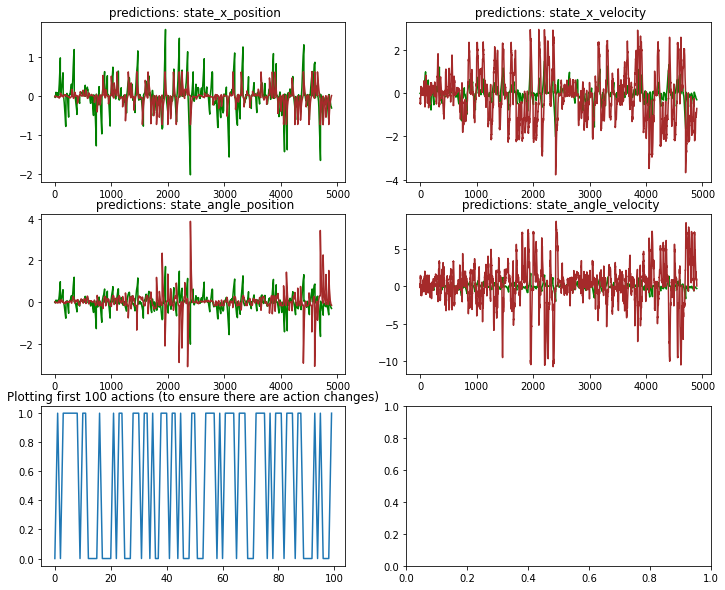

In [18]:
preds_sequentially = xgmodel.predict_sequentially(X, it_per_episode=50)

# Plot results graphs
label_count = np.shape(preds_sequentially)[1]
fig,axs = plt.subplots(3,2,)
for i in range(label_count):
    axs[i//2,i%2].set_title(f" predictions: {xgmodel.labels[i]}")
    axs[i//2,i%2].plot(y[:,0], "green")
    axs[i//2,i%2].plot(preds_sequentially[:,i], "brown")
    
# Plot action changes
action_idx = xgmodel.features.index(action_feat)
axs[(i+1)//2,(i+1)%2].set_title("Plotting first 100 actions (to ensure there are action changes)")
axs[(i+1)//2,(i+1)%2].plot(X[:100,action_idx])